In [1]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import seaborn as sns
sns.set_style("ticks")
sns.set()
sns.set_color_codes()

def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

In [45]:


dset_list = ['V1_JC085_20190624','V1_JC085_20190712','V1_JC097_20190621','V1_JC097_20190628',\
             'V1_JC097_20190704',\
             'LM_JC080_20190619','LM_JC091_20190621','LM_JC091_20190703','LM_JC091_20190628',\
             'LM_JC097_20190702','LM_JC097_20190708','LM_JC085_20190704',\
             'LI_JC091_20190625','LI_JC091_20190701','LI_JC091_20190705'
            ]


response_type = 'norm_df'

filter_crit = 'zscore'
filter_thresh = 1

#define paths
aggregate_root = '/n/coxfs01/cechavarria/2p-aggregate/scenes'
fig_out_dir = os.path.join(aggregate_root,'all','figures')

if not os.path.isdir(fig_out_dir):
        os.makedirs(fig_out_dir)

In [107]:
#get responses
area_list = ['V1','LM','LI']
animalid_list = []
sess_count = []
areaid = np.zeros((len(dset_list,)))
animalid = np.zeros((len(dset_list,)))
sessid = np.zeros((len(dset_list,)))

V1_response = []
LM_response = []
LI_response = []


for dset_idx, dset in enumerate(dset_list):
# dset_idx = 0
# dset = dset_list[dset_idx]

    #figure out some indexes
    i0 = findOccurrences(dset,'_')[0]
    i1 = findOccurrences(dset,'_')[1]

    area = dset[0:i0]
    animal = dset[i0+1:i1]
    session = dset[i1+1:]

    if animal not in animalid_list:
        animalid_list.append(animal)
        sess_count.append(0)

    sess_count[animalid_list.index(animal)] = sess_count[animalid_list.index(animal)]+1

    areaid[dset_idx] = area_list.index(area)
    animalid[dset_idx] = animalid_list.index(animal)
    sessid[dset_idx] = sess_count[animalid_list.index(animal)]-1


    #load data
    aggregate_file_dir = os.path.join(aggregate_root,area,'files')
    data_array_fn = '%s_%s_filtered_%s_responses_thresh_%s_%i.hdf5'%(animal, session, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')

    config_cond = np.array(data_grp['config_cond'])
    curr_slice = 'Slice01'#hard-code planar data for now
    
    active_cell_idx = np.array(data_grp['/'.join([curr_slice, 'active_cell_idx'])])
    dset_response = np.array(data_grp['/'.join([curr_slice, 'filtered_response_per_cfg_per_neuron'])])
    dset_response_active = dset_response[:,active_cell_idx]

    if area == 'V1':
        if len(V1_response)==0:
            V1_response = dset_response_active
        else:
            V1_response = np.hstack((V1_response, dset_response_active))
    elif area == 'LM':
        if len(LM_response)==0:
            LM_response = dset_response_active
        else:
            LM_response = np.hstack((LM_response, dset_response_active))
    elif area == 'LI':
        if len(LI_response)==0:
            LI_response = dset_response_active
        else:
            LI_response = np.hstack((LI_response, dset_response_active))

In [47]:
response_mean = np.zeros((V1_response.shape[0],3))
response_mean[:,0] = np.nanmean(V1_response,1)
response_mean[:,1] = np.nanmean(LM_response,1)
response_mean[:,2] = np.nanmean(LI_response,1)

response_mean = np.transpose(response_mean)

In [48]:
R_resp = np.corrcoef(response_mean)

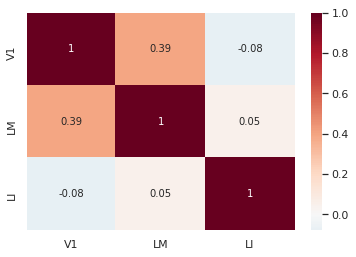

In [49]:
ax = sns.heatmap(R_resp,yticklabels=area_list,xticklabels = area_list,center = 0,annot=True, cmap = 'RdBu_r')

In [75]:
tmp = np.hstack((np.ones((1,30)),np.ones((1,30))*2))


In [80]:
response_mean2 = np.vstack((response_mean,tmp))

In [94]:
response_mean2.shape

(4, 60)

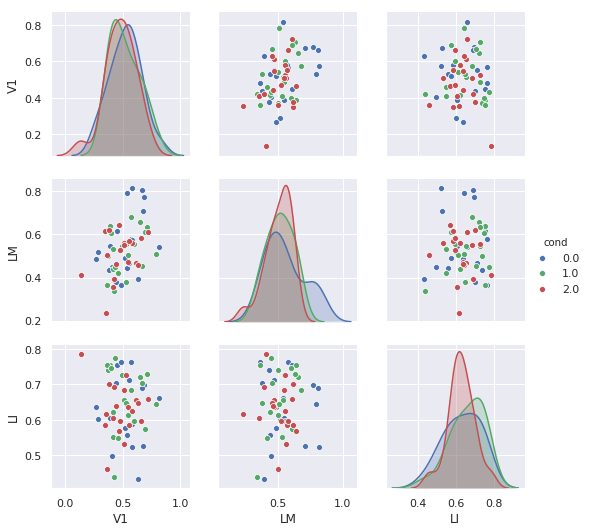

In [116]:
d = {'V1': response_mean[0,:], 'LM': response_mean[1,:],'LI': response_mean[2,:],\
    'cond': config_cond}
resp_df = pd.DataFrame(data=d)

palette = sns.color_palette(["#4c72b0","#55a868","#c44e52"])
sns.set_palette(palette)

sns.pairplot(resp_df,hue = 'cond',vars = ['V1','LM','LI'],diag_kind="kde")

In [40]:
#get responses
area_list = ['V1','LM','LI']
animalid_list = []
sess_count = []
areaid = np.zeros((len(dset_list,)))
animalid = np.zeros((len(dset_list,)))
sessid = np.zeros((len(dset_list,)))

dset_count= np.zeros((60,3))


for dset_idx, dset in enumerate(dset_list):
# dset_idx = 0
# dset = dset_list[dset_idx]

    #figure out some indexes
    i0 = findOccurrences(dset,'_')[0]
    i1 = findOccurrences(dset,'_')[1]

    area = dset[0:i0]
    animal = dset[i0+1:i1]
    session = dset[i1+1:]

    if animal not in animalid_list:
        animalid_list.append(animal)
        sess_count.append(0)

    sess_count[animalid_list.index(animal)] = sess_count[animalid_list.index(animal)]+1

    areaid[dset_idx] = area_list.index(area)
    animalid[dset_idx] = animalid_list.index(animal)
    sessid[dset_idx] = sess_count[animalid_list.index(animal)]-1


    #load data
    aggregate_file_dir = os.path.join(aggregate_root,area,'files')
    data_array_fn = '%s_%s_filtered_%s_responses_thresh_%s_%i.hdf5'%(animal, session, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')

    curr_slice = 'Slice01'#hard-code planar data for now
    dset_count[:,area_list.index(area)] = dset_count[:,area_list.index(area)]+ \
    np.array(data_grp['/'.join([curr_slice, 'active_rois_per_config'])])

dset_count = np.transpose(dset_count)

In [41]:

R_count = np.corrcoef(dset_count)

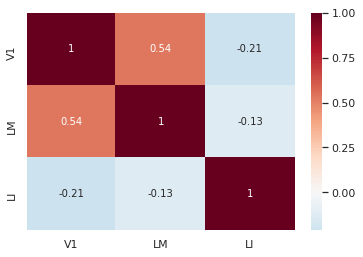

In [44]:
ax = sns.heatmap(R_count,yticklabels=area_list,xticklabels = area_list,center = 0,annot=True, cmap = 'RdBu_r')

In [117]:
dset_count.shape

(3, 60)

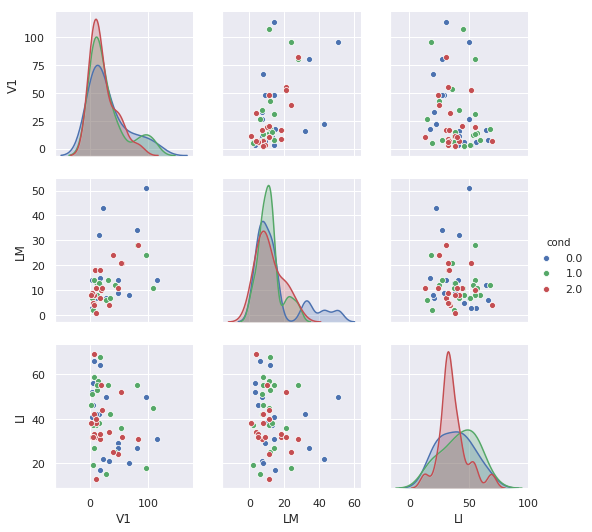

In [121]:
d = {'V1': dset_count[0,:], 'LM': dset_count[1,:],'LI': dset_count[2,:],\
    'cond': config_cond}
resp_df = pd.DataFrame(data=d)

palette = sns.color_palette(["#4c72b0","#55a868","#c44e52"])
sns.set_palette(palette)

sns.pairplot(resp_df,hue = 'cond',vars = ['V1','LM','LI'],diag_kind="kde",aspect = 1)

In [223]:
R_resp_area = np.zeros((np.unique(areaid).size,np.unique(areaid).size))
area_pairs = np.meshgrid(areaid,areaid)

for area_idx1 in np.unique(areaid):
    area_idx1 = int(area_idx1)
    for area_idx2 in np.unique(areaid):
        area_idx2 = int(area_idx2)

        M1 = np.array(area_pairs[0]==area_idx1).astype('float64')
        M2 = np.array(area_pairs[1]==area_idx2).astype('float64')

        M = M1*M2
       # M = np.tril(M,-1)
        M[np.diag_indices(M.shape[0])] = np.nan
        M[np.where(M==0)] = np.nan

        R_masked = R_resp*M

        R_resp_area[area_idx1,area_idx2]= np.nanmean(R_masked.flatten())

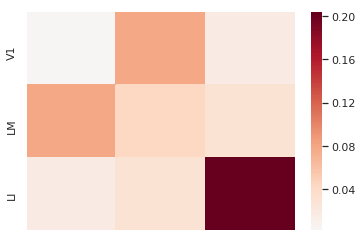

In [224]:
sns.heatmap(R_resp_area,yticklabels=area_list,xticklabels = False,center = 0, cmap = 'RdBu_r')

In [ ]:
# 

In [ ]:
#----Junk Code below here------